In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA']   = "1"
from os import path as osp
# if 'jupyter' in os.getcwd():
#     os.chdir(osp.join(os.getcwd(), 'masterarbeit', 'code'))
import glob
import time
import argparse
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdmnotebook
import pickle
from pathlib import Path
from typing import Any
from typing import Callable
from typing import Optional
from typing import Tuple
from typing import Union
from typing import Dict
from typing import List
from itertools import cycle
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
mpl.rc('axes', unicode_minus=False)
preamble = r'\usepackage{amsmath}'  # LaTeX preamble command
mpl.rcParams['text.latex.preamble'] = preamble

# import seaborn as sns
import networkx as nx
import math
import numpy as np

import gc

# pytorch imports
import torch
from torch import Tensor, nn, cuda
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.cuda.amp import GradScaler, autocast

# pytorch geometric imports
import torch_geometric
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import Compose

# lightning imports
from lightning.pytorch.utilities.combined_loader import CombinedLoader

from IPython.display import display, clear_output

from google.cloud import storage

import sys
# Add the 'code' directory to sys.path to make the  submodules available
# sys.path.append('/home/jupyter/masterarbeit/code')

from util.utils import generate_log_name
from util.plot_utils import *

import logging as log

from data.dataset.GraphDataset import GraphDataset

from model.transform import CollapseChannels, ExtractSquare
from model.autoencoder import Autoencoder
from model.predictor import Predictor
from model.DAN import GradientReversalLayer, DomainDiscriminator

from model.criterions import WeightedMSELoss, MSLELoss, FocalLoss, ZeroInflatedLoss, CustomHuberLoss

from fullmodel import Model

In [2]:
exp_id='exp07'

In [3]:
NUM_WORKERS: int = 0
BATCH_SIZE: int = 64
NUM_CHANNELS: int = 2
WDW_LENGTH: list = [12, 6]

# Constants that I may change a bit during testing
tgt: str = 'MELBOURNE'
src_list: list = ['ANTWERP']
# src_list: list = ['ANTWERP', 'BANGKOK', 'BARCELONA', 'BERLIN', 'CHICAGO', 'ISTANBUL', 'MOSCOW'] # 7 cities
EPOCHS: int = 2
tgt_data_limit: int = 1680
src_data_limit: int = None
LOGGING: int = 1

if src_data_limit == -1:
    src_data_limit = None

# Get data from bucket
bucket_name = 'cloud-ai-platform-054ad037-69b6-4c4d-94a1-75d2591213c7'
bucket_folder = 'data/graphs'
local_folder  = 'data/graphs'
download_directory(bucket_name, bucket_folder, local_folder)
bucket_folder = 'data/raw'
local_folder  = 'data/raw'
download_directory(bucket_name, bucket_folder, local_folder)

bucket_output = 'output/models/'

# Constants that I don't intend to change much
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TRAIN_VAL_TEST_SPLIT = [0.8, 0.1, 0.1]

pre_transform = Compose([
    CollapseChannels(),
    ExtractSquare(50, 'central'),
])

static_transform = Compose([
    ExtractSquare(50, 'central'),
])

ds_kwargs = {
    'root_dir': 'data/raw',
    'device': device,
    'pre_transform': pre_transform,
    'static_transform': static_transform,
}

# seed generator for DataLoader
torch.manual_seed(2311)

# Create datasets for each city
ds_dict = {}
for city in src_list:
    ds_dict[city] = GraphDataset(
        cities=[city],
        limit=src_data_limit,
        **ds_kwargs,
    )
    
temp_tgt = GraphDataset(
    cities=[tgt],
    limit=None,
    **ds_kwargs,
)

train_tgt, val_tgt, test_tgt = random_split(
    temp_tgt, [0.08, 0.08, 0.84]
)


train_tgt = DataLoader(train_tgt, batch_size=BATCH_SIZE, shuffle=True,  drop_last=True)
val_tgt   = DataLoader(  val_tgt, batch_size=BATCH_SIZE, shuffle=True,  drop_last=True)
test_tgt  = DataLoader( test_tgt, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
# Split each dataset into training and test sets
train = {}
val   = {}
test  = {}
for city in ds_dict:
    train_ds, val_ds, test_ds = random_split(
        ds_dict[city], TRAIN_VAL_TEST_SPLIT
    )
    train[city] = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  drop_last=True)
    val[city]   = DataLoader(  val_ds, batch_size=BATCH_SIZE, shuffle=True,  drop_last=True)
    test[city]  = DataLoader( test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

train[tgt] = train_tgt
val[tgt]   = val_tgt
test[tgt]  = test_tgt

# Create dataloader for offline training with source cities
source_train = {city: train[city] for city in src_list}
source_dataloader = CombinedLoader(source_train, mode='max_size_cycle')

source_test = {city: test[city] for city in src_list}
sourcetest_dataloader = CombinedLoader(source_test, mode='max_size_cycle')

target_dataloader = CombinedLoader({tgt: train[tgt]}, mode='max_size_cycle')
targettest_dataloader = CombinedLoader({tgt: test[tgt]}, mode='max_size_cycle')

# Create dataloader for online training with source and target cities
train_dataloader = CombinedLoader(train, mode='max_size_cycle')

# Create dataloader for validation with source and target cities
val_dataloader = CombinedLoader(val, mode='max_size_cycle')

# Create dataloader for testing with source and target cities
test_dataloader = CombinedLoader(test, mode='max_size_cycle')

Epochs:   0%|          | 0/2 [00:00<?,?it/s]

Batches:   0%|          | 0/541 [00:00<?,?it/s]

Batch:  50
    Loss:  573.8077
     Rec:    0.0035
    Disc:    0.4286
Batch:  100
    Loss:  406.4892
     Rec:    0.0023
    Disc:    0.3773
Batch:  150
    Loss:  345.9274
     Rec:    0.0015
    Disc:    0.3316
Batch:  200
    Loss:  274.2139
     Rec:    0.0012
    Disc:    0.3876
    Val Disc: 0.447


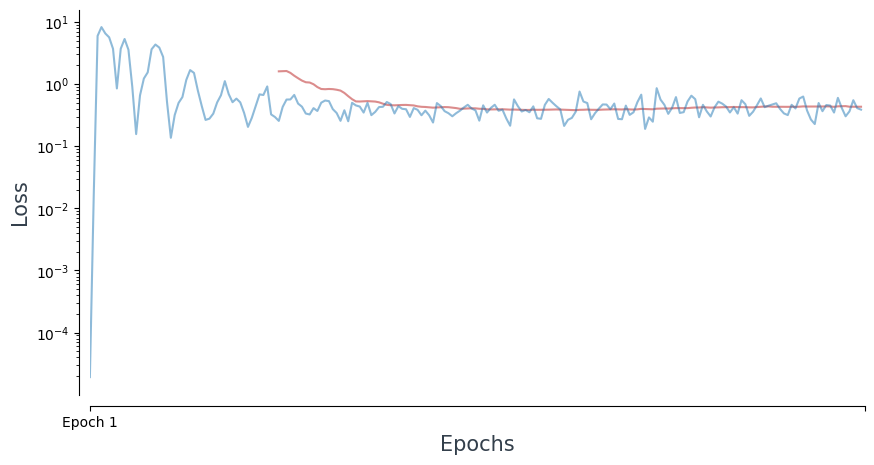

Batch:  250
    Loss:  250.9253
     Rec:    0.0010
    Disc:    0.3841
Batch:  300
    Loss:  230.0127
     Rec:    0.0009
    Disc:    0.4833
Batch:  350
    Loss:  214.2399
     Rec:    0.0008
    Disc:    0.3808
Batch:  400
    Loss:  217.7621
     Rec:    0.0007
    Disc:    0.4351
    Val Disc: 0.506


<Figure size 640x480 with 0 Axes>

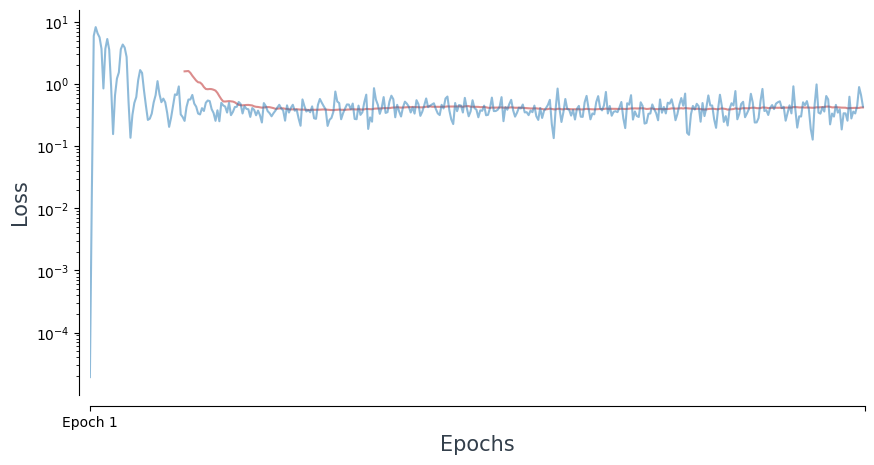

Batch:  450
    Loss:  204.3070
     Rec:    0.0007
    Disc:    0.3169
Batch:  500
    Loss:  187.9274
     Rec:    0.0006
    Disc:    0.6146
Batch:  50
    Loss:  243.0706
     Rec:    0.0006
    Disc:    0.2058
Batch:  100
    Loss:  220.9163
     Rec:    0.0006
    Disc:    0.6509
Batch:  150
    Loss:  235.4418
     Rec:    0.0005
    Disc:    0.5164
Batch:  200
    Loss:  207.2543
     Rec:    0.0005
    Disc:    0.5142
    Val Disc: 0.497


<Figure size 640x480 with 0 Axes>

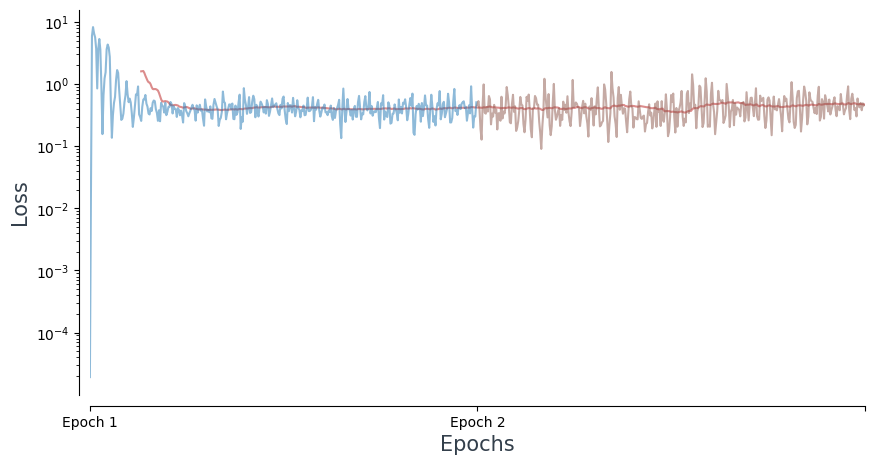

Batch:  250
    Loss:  227.9954
     Rec:    0.0005
    Disc:    0.6599
Batch:  300
    Loss:  211.0231
     Rec:    0.0005
    Disc:    0.4922
Batch:  350
    Loss:  209.3646
     Rec:    0.0005
    Disc:    0.3854
    Val Disc: 0.507


<Figure size 640x480 with 0 Axes>

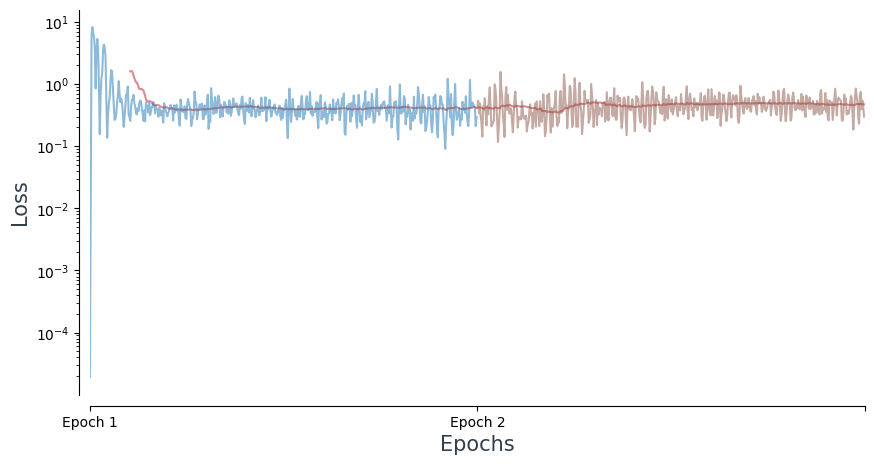

Batch:  450
    Loss:  220.6186
     Rec:    0.0005
    Disc:    0.5084
Batch:  500
    Loss:  206.7336
     Rec:    0.0004
    Disc:    0.6375


<Figure size 640x480 with 0 Axes>

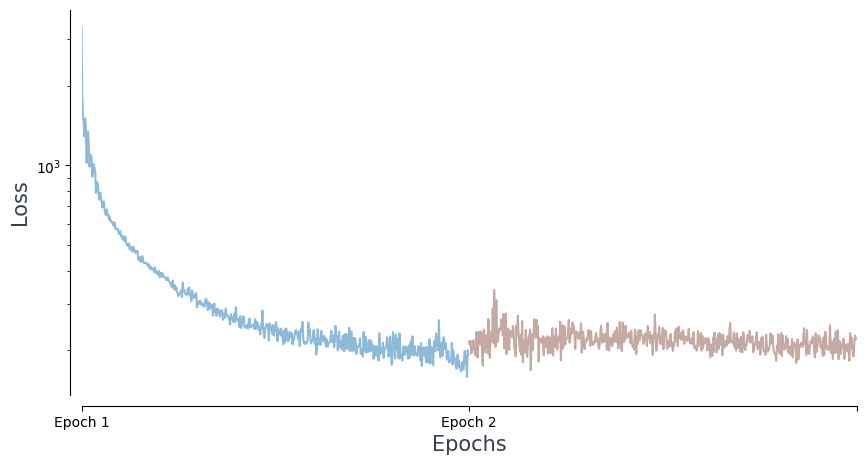

<Figure size 640x480 with 0 Axes>

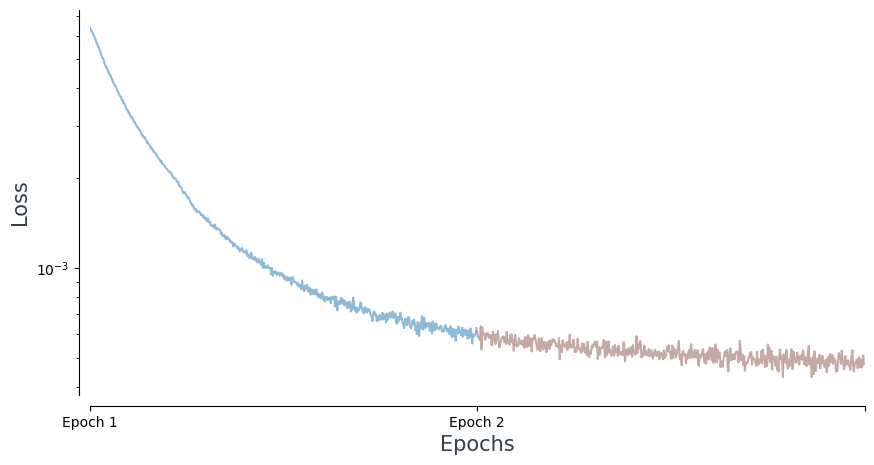

<Figure size 640x480 with 0 Axes>

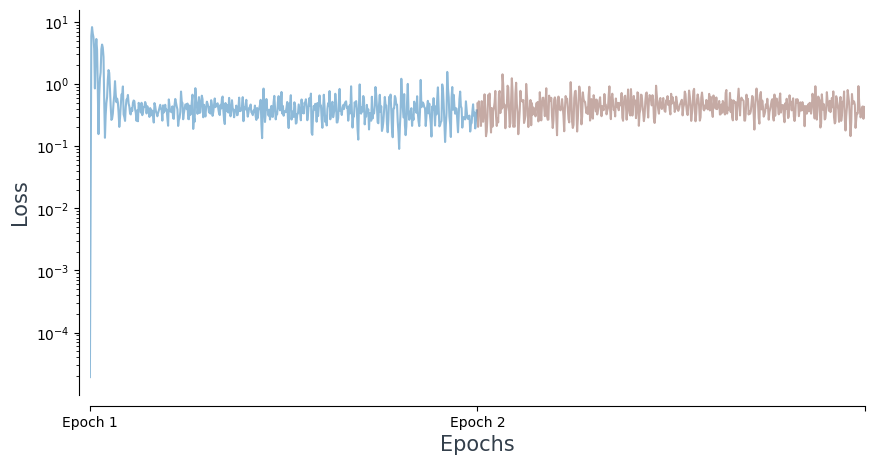

Epochs:   0%|          | 0/2 [00:00<?,?it/s]

Batches:   0%|          | 0/55 [00:00<?,?it/s]

Batch:  50
    Loss:   26.4928
     Rec:    0.0004
    Disc:    0.0001
Batch:  50
    Loss:   25.9996
     Rec:    0.0004
    Disc:    0.0001


Epochs:   0%|          | 0/2 [00:00<?,?it/s]

Batches:   0%|          | 0/541 [00:00<?,?it/s]

Batch:  0
    Loss:  289.2471


<Figure size 640x480 with 0 Axes>

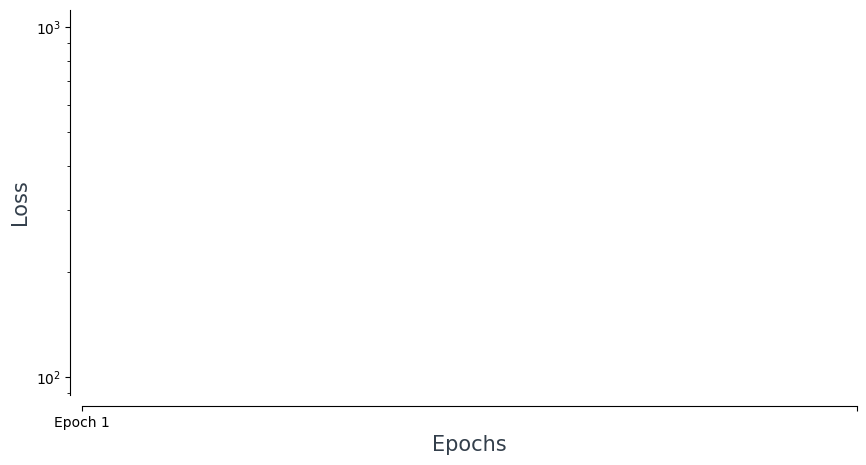

Batch:  50
    Loss:  162.5666
Batch:  100
    Loss:  151.0864
Batch:  150
    Loss:  132.8349
Batch:  200
    Loss:  136.6119


<Figure size 640x480 with 0 Axes>

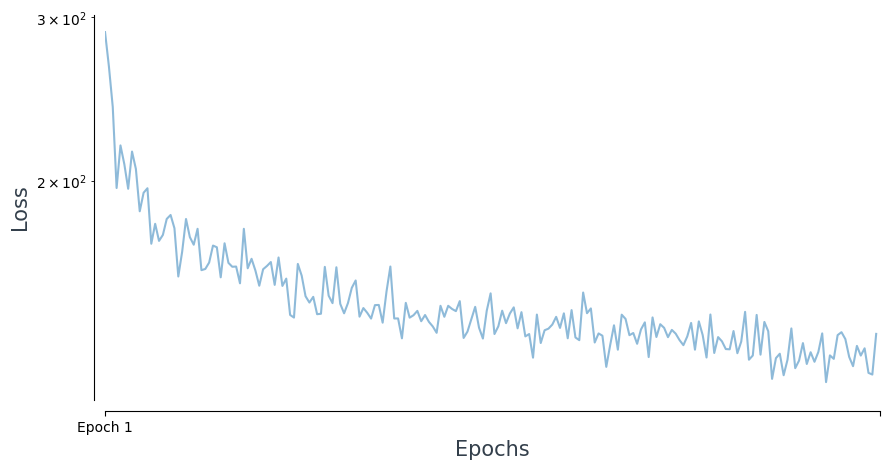

Batch:  250
    Loss:  123.0005
Batch:  300
    Loss:  125.2594
Batch:  350
    Loss:  121.0678
Batch:  450
    Loss:  115.0922
Batch:  500
    Loss:  112.1165
Batch:  0
    Loss:  115.9658


<Figure size 640x480 with 0 Axes>

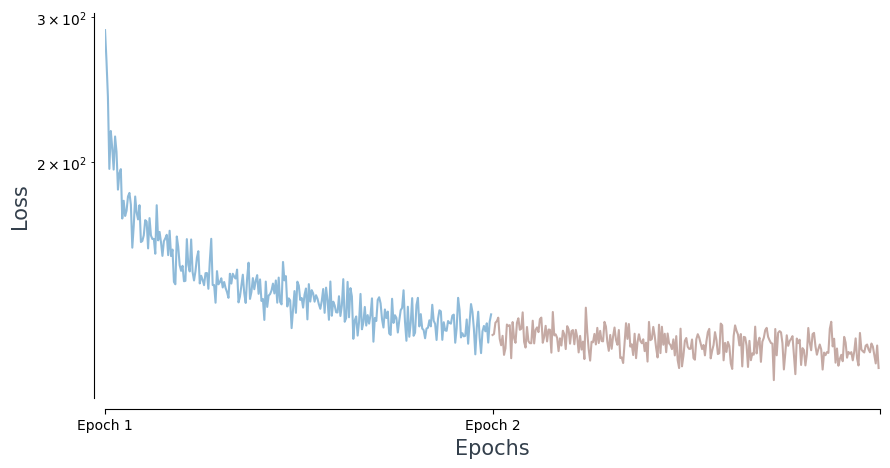

Batch:  50
    Loss:  119.0490
Batch:  100
    Loss:  109.2031
Batch:  150
    Loss:  117.3247
Batch:  200
    Loss:  112.5305


<Figure size 640x480 with 0 Axes>

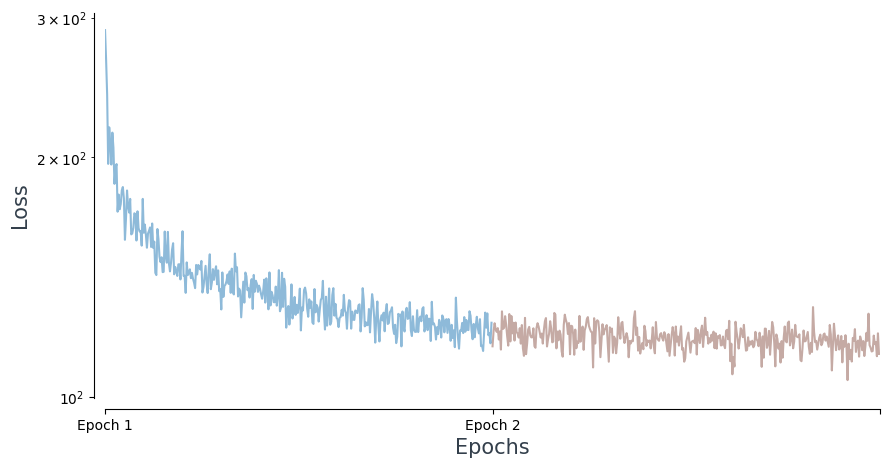

Batch:  250
    Loss:  113.9176
Batch:  300
    Loss:  116.8377
Batch:  350
    Loss:  116.8484
Batch:  400
    Loss:  116.7711


<Figure size 640x480 with 0 Axes>

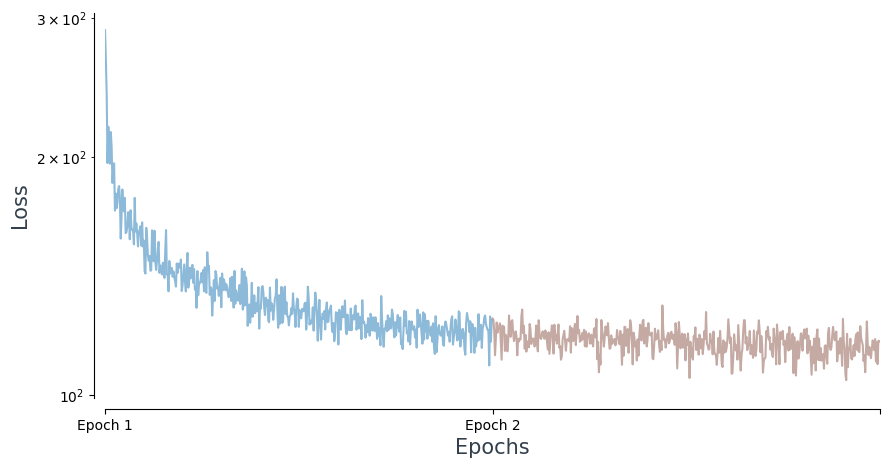

Batch:  450
    Loss:  118.7094
Batch:  500
    Loss:  115.9947


Epochs:   0%|          | 0/2 [00:00<?,?it/s]

Batches:   0%|          | 0/55 [00:00<?,?it/s]

Batch:  0
    Loss:   32.6401


<Figure size 640x480 with 0 Axes>

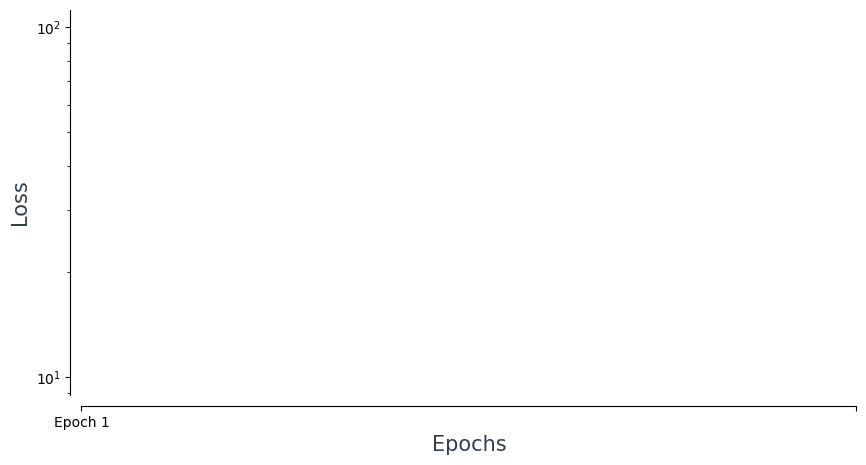

Batch:  50
    Loss:   29.0793


Batches:   0%|          | 0/568 [00:00<?,?it/s]

<Figure size 640x480 with 0 Axes>

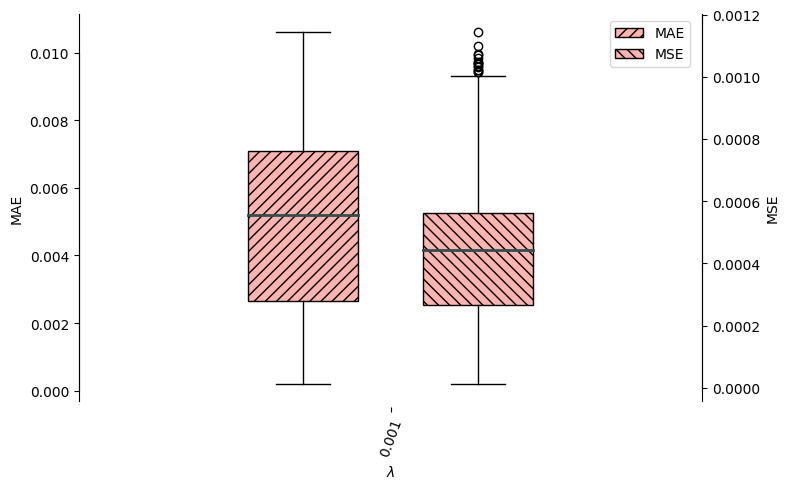

Epochs:   0%|          | 0/2 [00:00<?,?it/s]

Batches:   0%|          | 0/541 [00:00<?,?it/s]

Batch:  50
    Loss:  767.0496
     Rec:    0.0018
    Disc:    0.2697
Batch:  100
    Loss:  582.4893
     Rec:    0.0012
    Disc:    0.8010
Batch:  150
    Loss:  420.4045
     Rec:    0.0009
    Disc:    0.4713
Batch:  200
    Loss:  407.3784
     Rec:    0.0008
    Disc:    0.2567
    Val Disc: 0.500


/home/jupyter/masterarbeit/code/util/plot_utils.py:184: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(bottom=0)


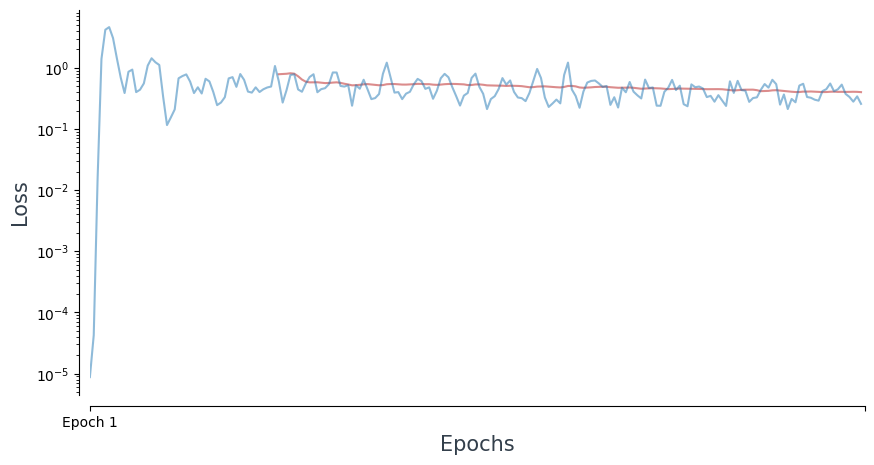

Batch:  250
    Loss:  375.4701
     Rec:    0.0007
    Disc:    0.3417
Batch:  300
    Loss:  383.5909
     Rec:    0.0006
    Disc:    0.2765
Batch:  350
    Loss:  438.6879
     Rec:    0.0006
    Disc:    0.4725
Batch:  400
    Loss:  651.6393
     Rec:    0.0005
    Disc:    1.0362
    Val Disc: 0.418


<Figure size 640x480 with 0 Axes>

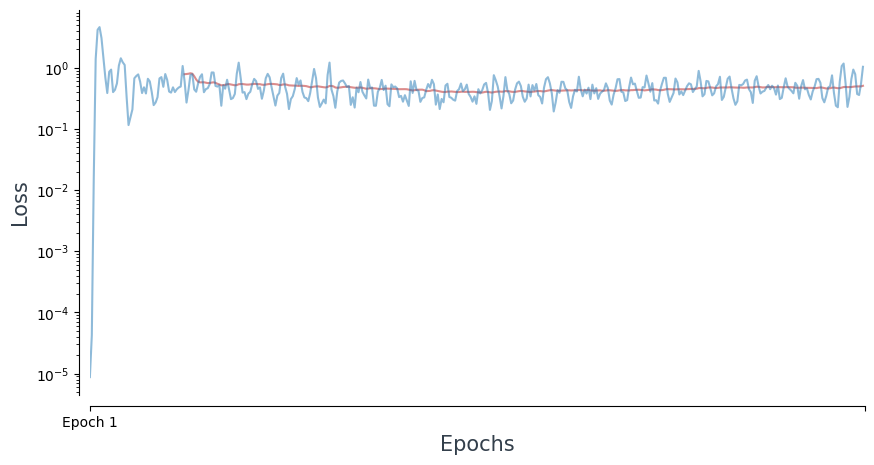

Batch:  450
    Loss:  356.2914
     Rec:    0.0005
    Disc:    0.3735
Batch:  500
    Loss:  341.9794
     Rec:    0.0005
    Disc:    0.3216
Batch:  50
    Loss:  607.4899
     Rec:    0.0004
    Disc:    0.2270
Batch:  100
    Loss:  451.3965
     Rec:    0.0004
    Disc:    0.4462
Batch:  150
    Loss:  589.5345
     Rec:    0.0004
    Disc:    0.7969
Batch:  200
    Loss:  679.5416
     Rec:    0.0004
    Disc:    0.3274
    Val Disc: 0.514


<Figure size 640x480 with 0 Axes>

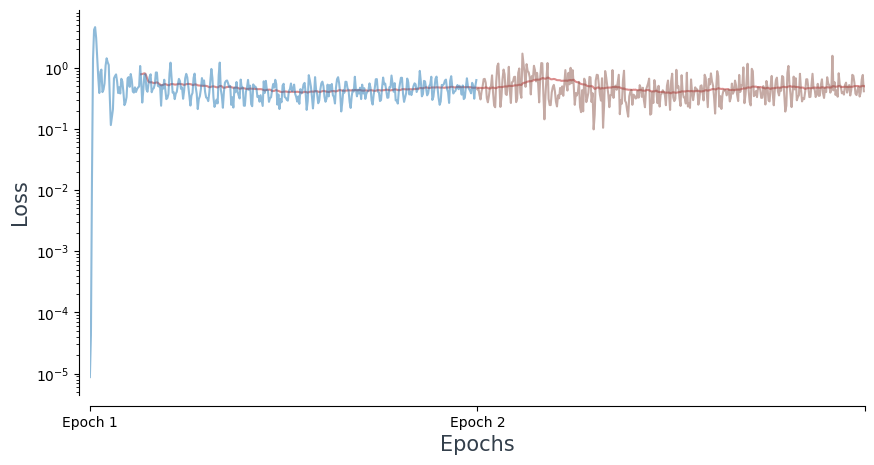

Batch:  250
    Loss:  471.8192
     Rec:    0.0004
    Disc:    0.3716
Batch:  300
    Loss:  701.4875
     Rec:    0.0004
    Disc:    0.8091
Batch:  350
    Loss:  529.4045
     Rec:    0.0004
    Disc:    0.2993
Batch:  400
    Loss:  493.5203
     Rec:    0.0004
    Disc:    0.5178
    Val Disc: 0.477


<Figure size 640x480 with 0 Axes>

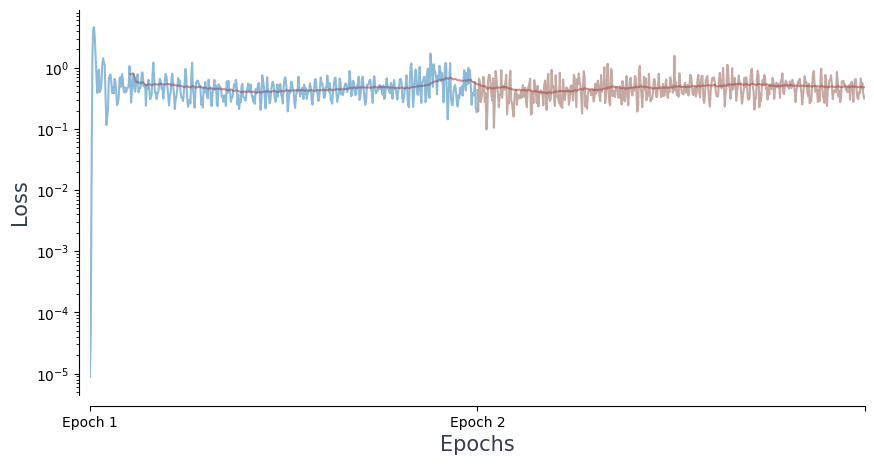

Batch:  450
    Loss:  559.2351
     Rec:    0.0004
    Disc:    0.4056
Batch:  500
    Loss:  490.1794
     Rec:    0.0004
    Disc:    0.4673


<Figure size 640x480 with 0 Axes>

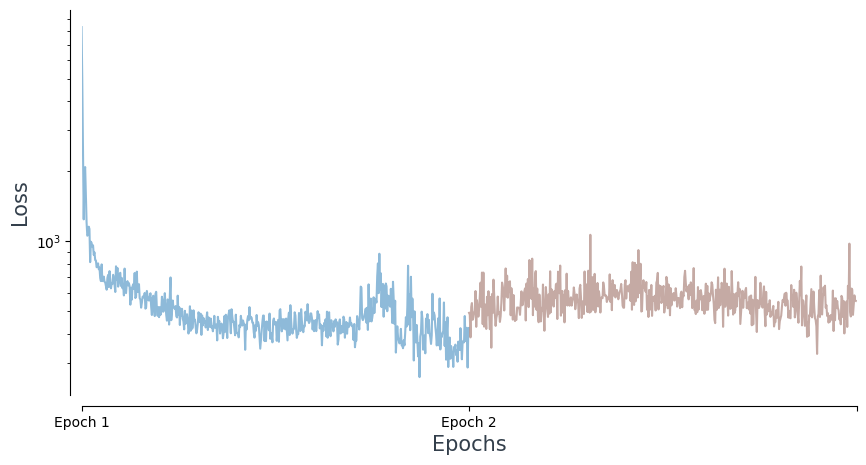

<Figure size 640x480 with 0 Axes>

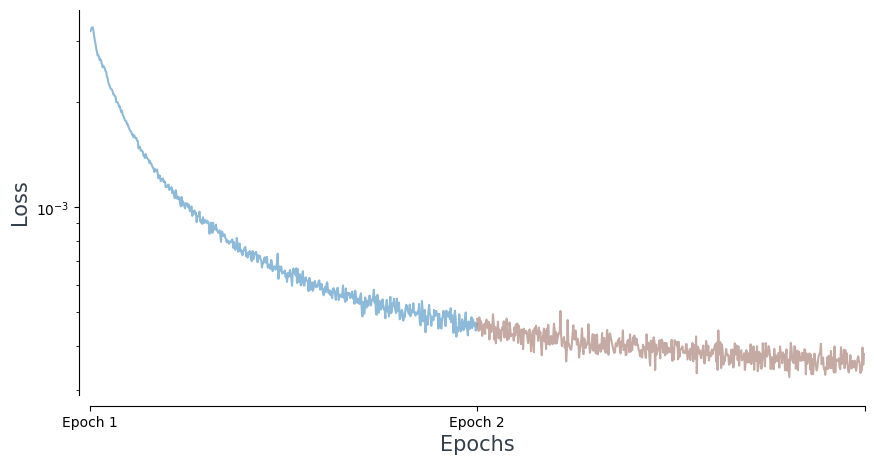

<Figure size 640x480 with 0 Axes>

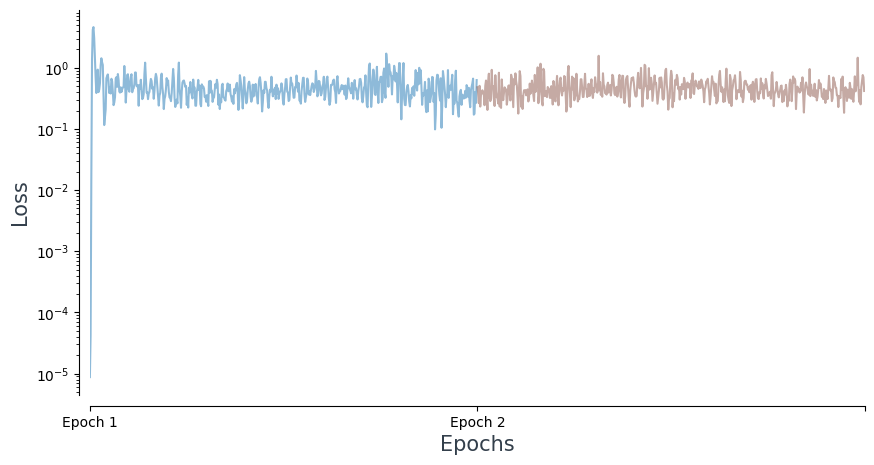

Epochs:   0%|          | 0/2 [00:00<?,?it/s]

Batches:   0%|          | 0/55 [00:00<?,?it/s]

Batch:  50
    Loss:   23.0326
     Rec:    0.0003
    Disc:    0.0008
Batch:  50
    Loss:   20.2886
     Rec:    0.0003
    Disc:    0.0000


Epochs:   0%|          | 0/2 [00:00<?,?it/s]

Batches:   0%|          | 0/541 [00:00<?,?it/s]

Batch:  0
    Loss:  201.7777


<Figure size 640x480 with 0 Axes>

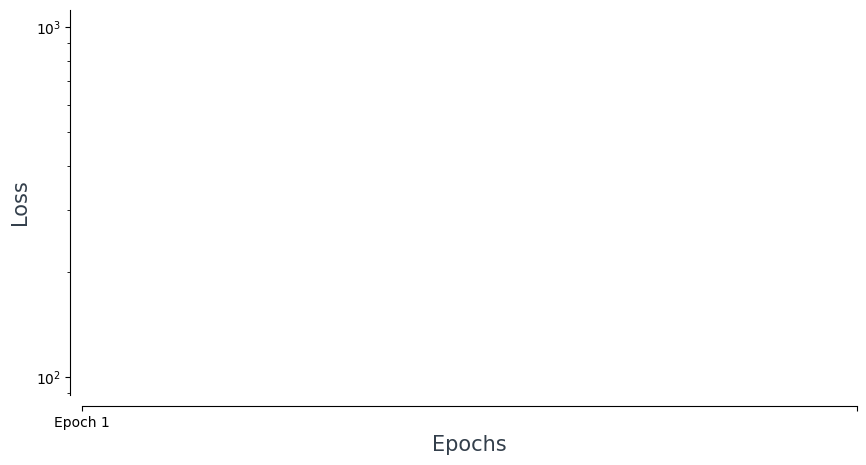

Batch:  50
    Loss:  166.2525
Batch:  100
    Loss:  152.6519
Batch:  150
    Loss:  148.5388
Batch:  200
    Loss:  142.3504


<Figure size 640x480 with 0 Axes>

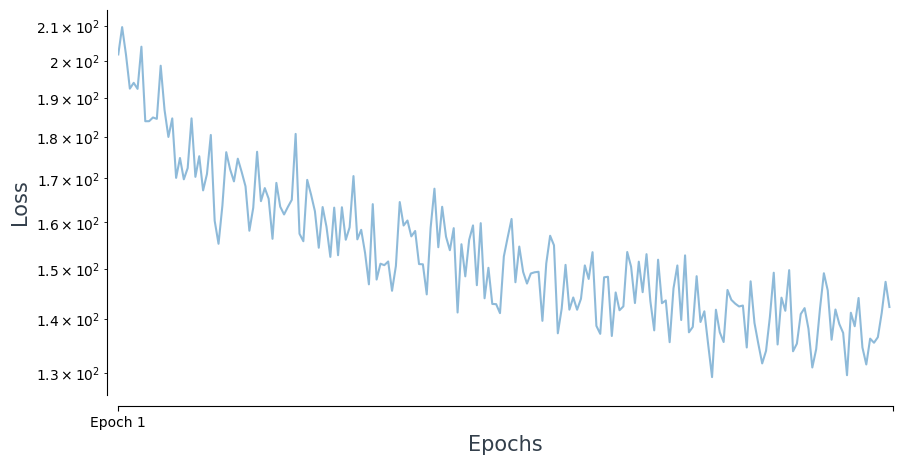

Batch:  250
    Loss:  131.0361
Batch:  300
    Loss:  125.2134
Batch:  350
    Loss:  131.7764
Batch:  400
    Loss:  132.3866


<Figure size 640x480 with 0 Axes>

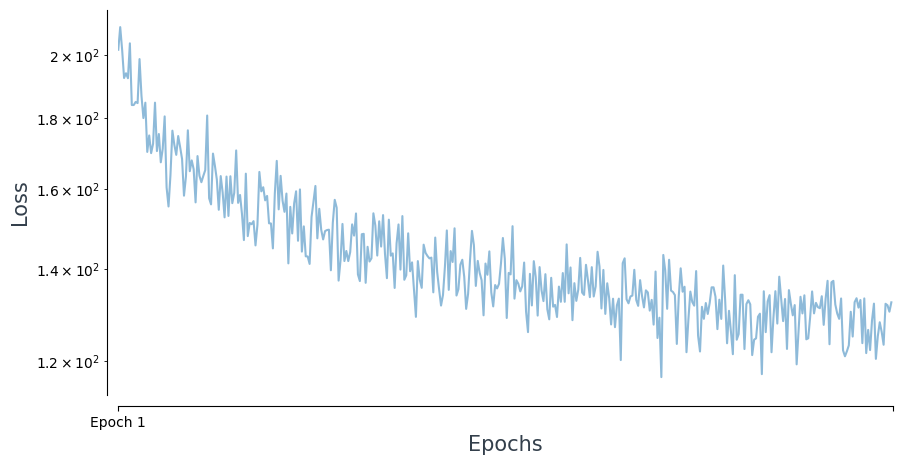

Batch:  450
    Loss:  121.6510
Batch:  500
    Loss:  127.5460
Batch:  0
    Loss:  116.5483


<Figure size 640x480 with 0 Axes>

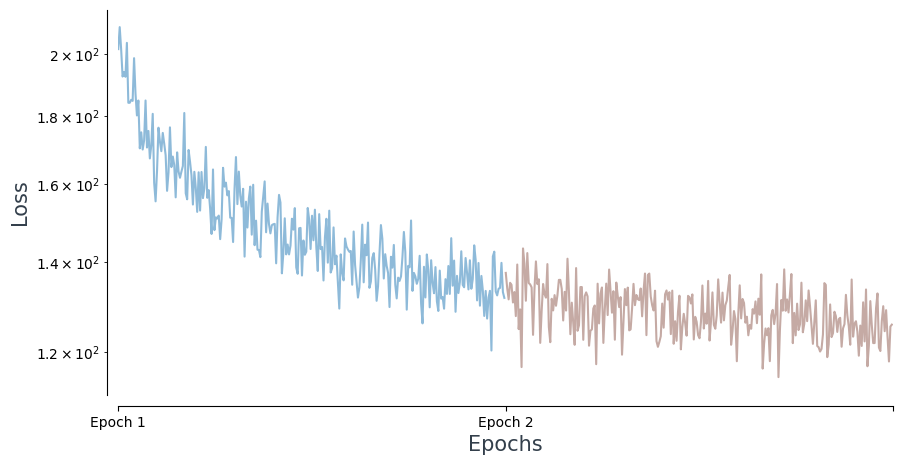

Batch:  50
    Loss:  123.8368
Batch:  100
    Loss:  126.2774
Batch:  150
    Loss:  119.8607
Batch:  250
    Loss:  118.9023
Batch:  300
    Loss:  112.8878
Batch:  350
    Loss:  119.3954
Batch:  400
    Loss:  114.0695


<Figure size 640x480 with 0 Axes>

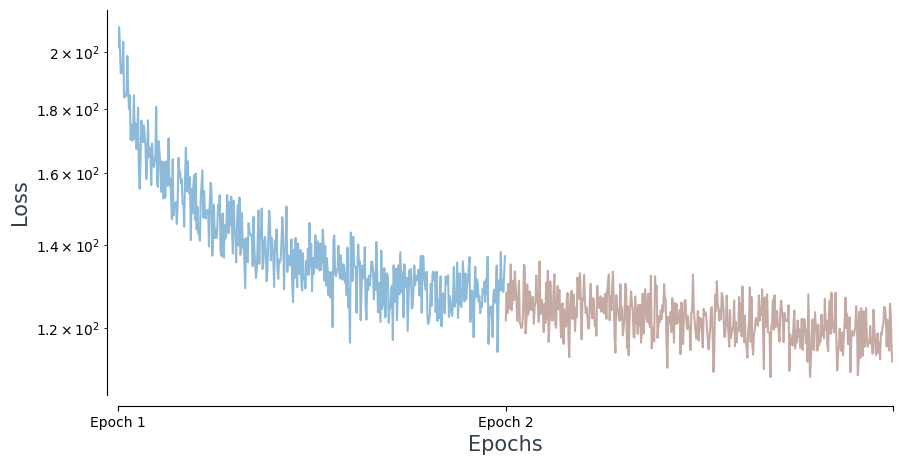

Batch:  450
    Loss:  116.3918
Batch:  500
    Loss:  118.8077


Epochs:   0%|          | 0/2 [00:00<?,?it/s]

Batches:   0%|          | 0/55 [00:00<?,?it/s]

Batch:  0
    Loss:   30.8435


<Figure size 640x480 with 0 Axes>

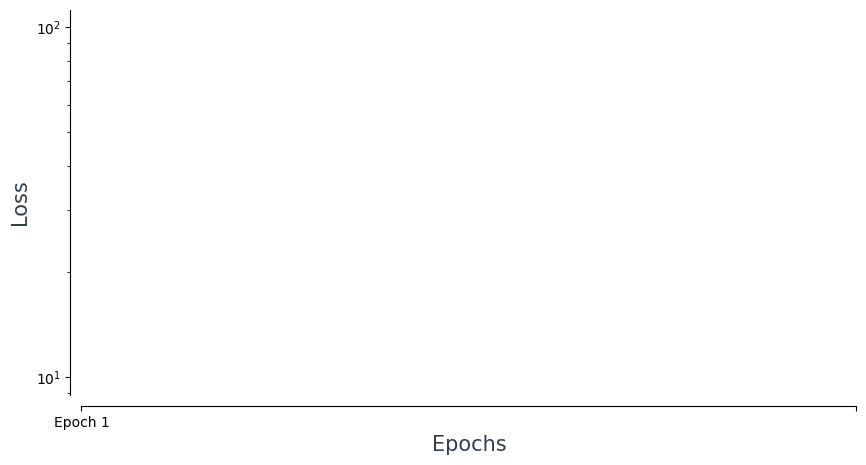

Batch:  50
    Loss:   28.2560
Batch:  0
    Loss:   29.0162


<Figure size 640x480 with 0 Axes>

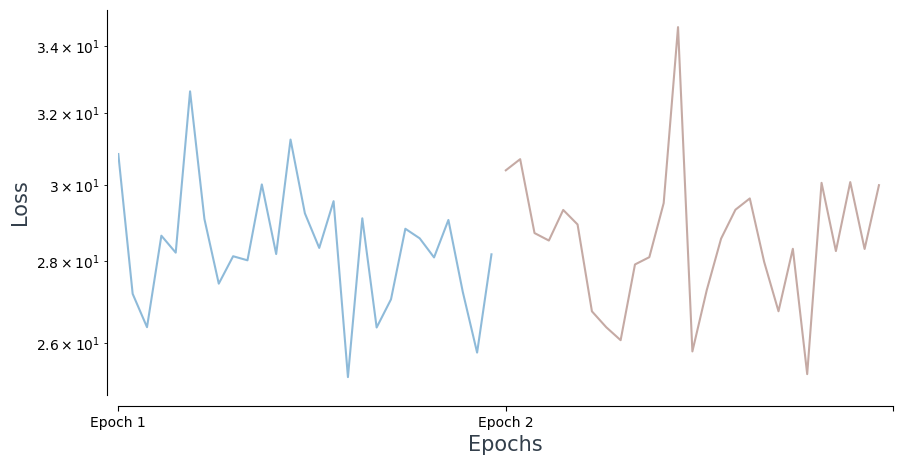

Batch:  50
    Loss:   26.5675


Batches:   0%|          | 0/568 [00:00<?,?it/s]

<Figure size 640x480 with 0 Axes>

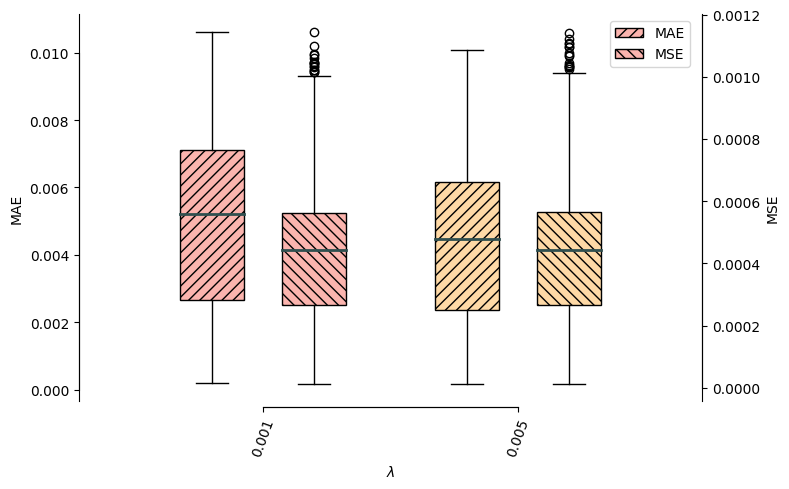

Epochs:   0%|          | 0/2 [00:00<?,?it/s]

Batches:   0%|          | 0/541 [00:00<?,?it/s]

Batch:  50
    Loss: 1252.8319
     Rec:    0.0036
    Disc:    0.5322
Batch:  100
    Loss: 1229.8739
     Rec:    0.0023
    Disc:    0.3062
Batch:  150
    Loss:  988.1261
     Rec:    0.0017
    Disc:    0.4377
Batch:  200
    Loss:  997.1132
     Rec:    0.0013
    Disc:    0.3559
    Val Disc: 0.416


/home/jupyter/masterarbeit/code/util/plot_utils.py:184: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(bottom=0)


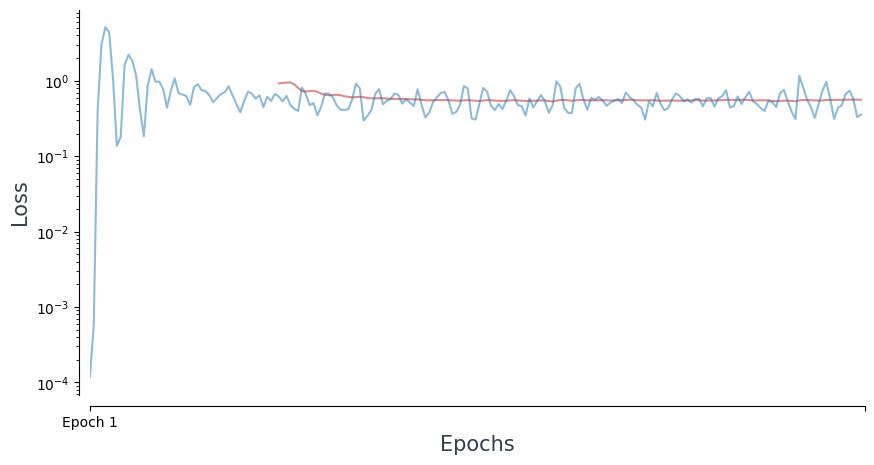

Batch:  250
    Loss:  959.8366
     Rec:    0.0011
    Disc:    0.6668
Batch:  300
    Loss:  887.3882
     Rec:    0.0010
    Disc:    0.4620
Batch:  350
    Loss:  956.7650
     Rec:    0.0009
    Disc:    0.5934
Batch:  400
    Loss: 1147.6698
     Rec:    0.0009
    Disc:    0.5522
    Val Disc: 0.518


<Figure size 640x480 with 0 Axes>

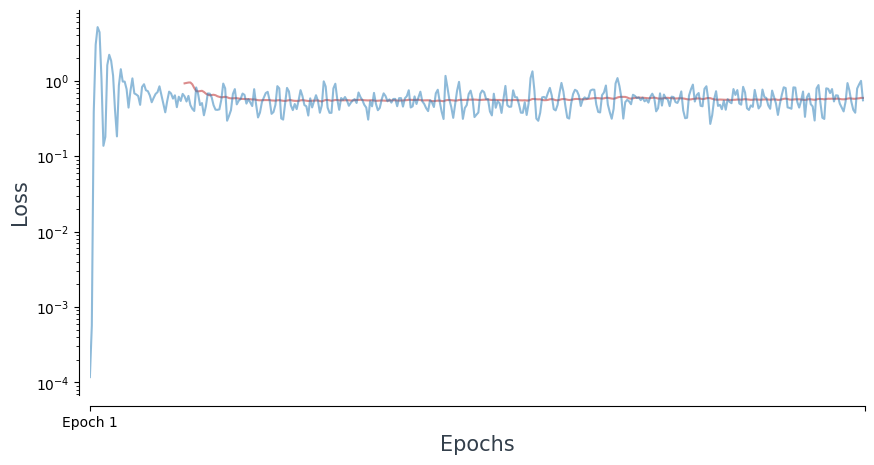

Batch:  450
    Loss: 1124.6263
     Rec:    0.0008
    Disc:    1.0151
Batch:  500
    Loss:  968.2916
     Rec:    0.0007
    Disc:    0.3735
Batch:  50
    Loss: 1495.0938
     Rec:    0.0007
    Disc:    0.3393
Batch:  100
    Loss: 1219.1586
     Rec:    0.0007
    Disc:    0.5114
Batch:  150
    Loss: 1588.2699
     Rec:    0.0006
    Disc:    1.0635
Batch:  200
    Loss: 1467.3688
     Rec:    0.0006
    Disc:    0.6082
    Val Disc: 0.504


<Figure size 640x480 with 0 Axes>

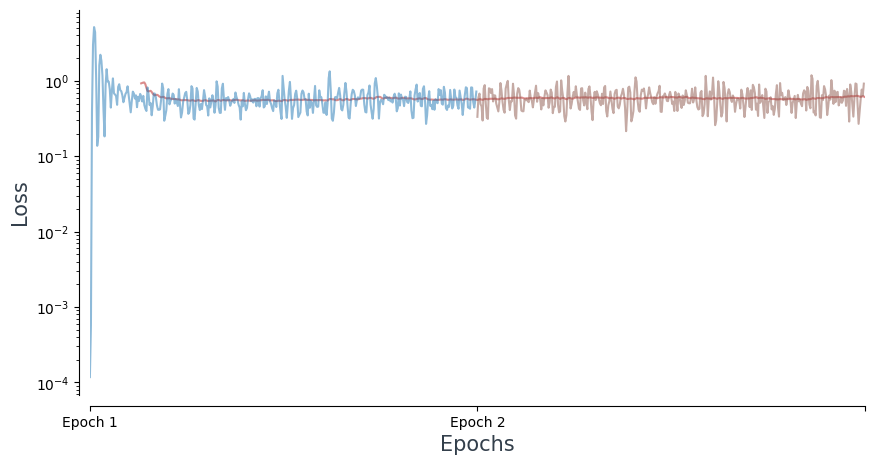

Batch:  250
    Loss: 1175.0759
     Rec:    0.0006
    Disc:    0.3905
Batch:  300
    Loss: 1207.0139
     Rec:    0.0006
    Disc:    0.4966
Batch:  350
    Loss: 1417.3250
     Rec:    0.0006
    Disc:    0.5196
Batch:  400
    Loss: 1392.6840
     Rec:    0.0006
    Disc:    0.5793
    Val Disc: 0.206


<Figure size 640x480 with 0 Axes>

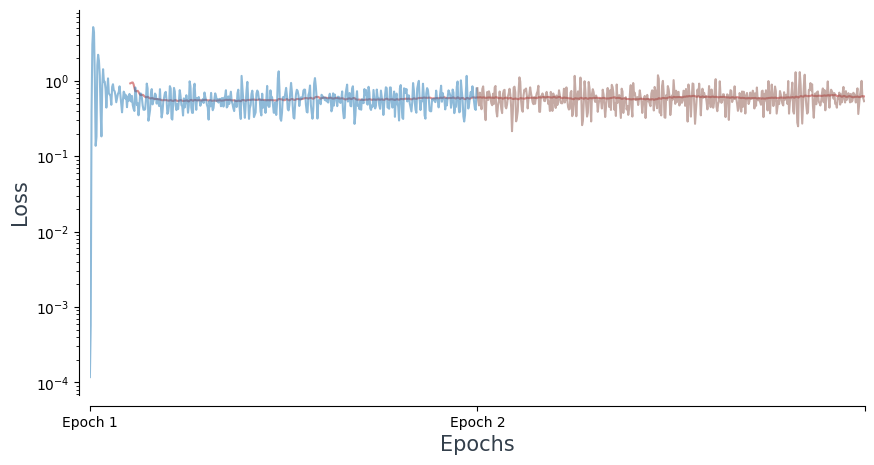

Batch:  450
    Loss: 1425.1490
     Rec:    0.0005
    Disc:    0.4635
Batch:  500
    Loss: 1693.6385
     Rec:    0.0005
    Disc:    0.4946


<Figure size 640x480 with 0 Axes>

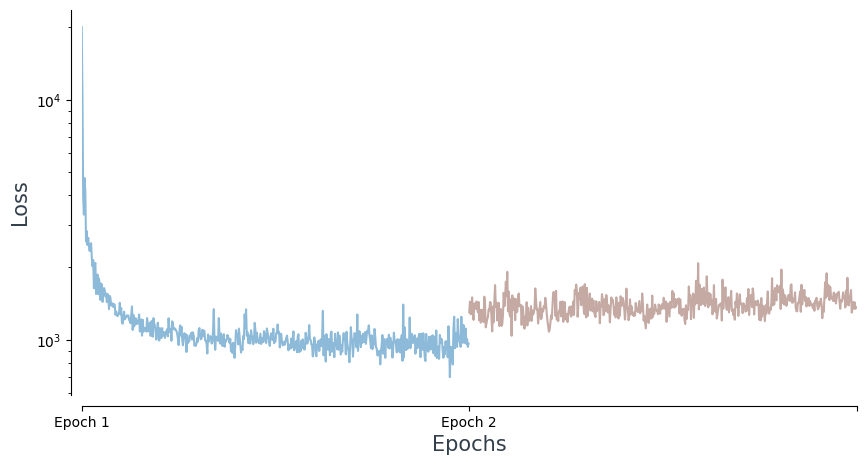

<Figure size 640x480 with 0 Axes>

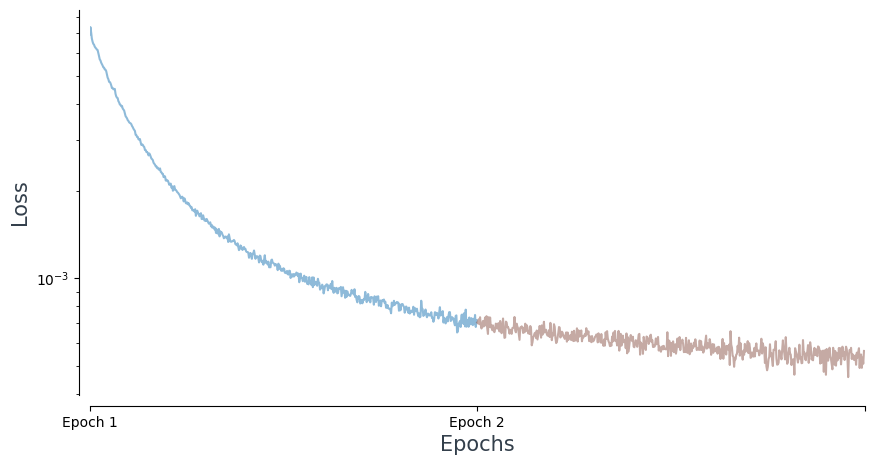

<Figure size 640x480 with 0 Axes>

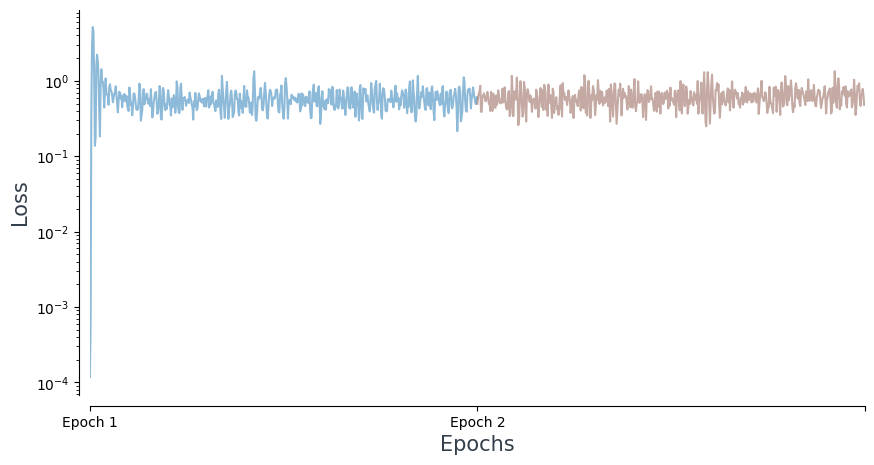

Epochs:   0%|          | 0/2 [00:00<?,?it/s]

Batches:   0%|          | 0/55 [00:00<?,?it/s]

Batch:  50
    Loss:   28.9500
     Rec:    0.0004
    Disc:    0.0005
Batch:  50
    Loss:   32.7082
     Rec:    0.0005
    Disc:    0.0000


Epochs:   0%|          | 0/2 [00:00<?,?it/s]

Batches:   0%|          | 0/541 [00:00<?,?it/s]

Batch:  0
    Loss:  764.5974


<Figure size 640x480 with 0 Axes>

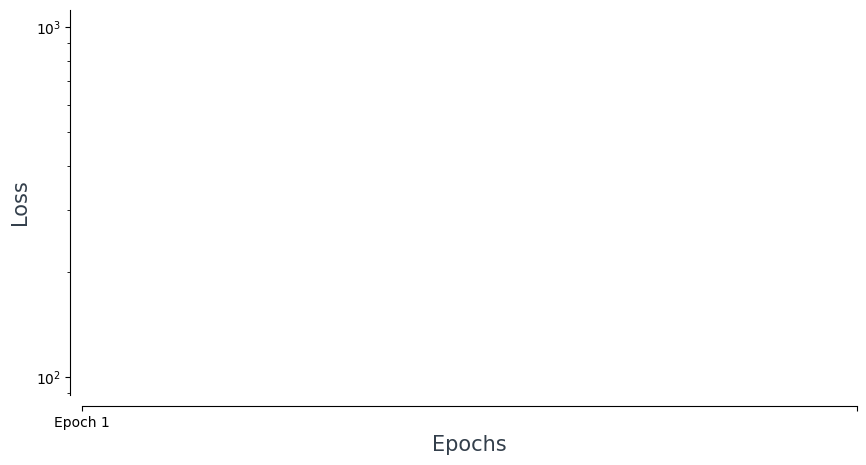

Batch:  50
    Loss:  175.9290
Batch:  100
    Loss:  179.1209
Batch:  150
    Loss:  180.8308
Batch:  200
    Loss:  179.5774


<Figure size 640x480 with 0 Axes>

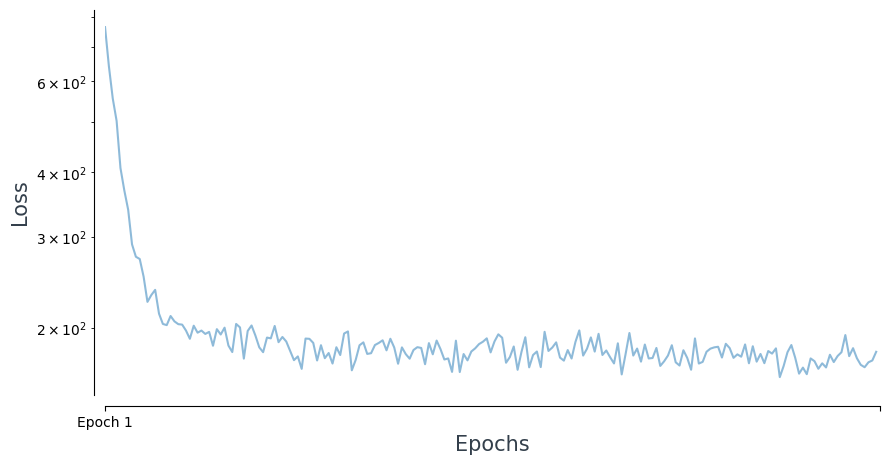

Batch:  250
    Loss:  175.5307
Batch:  300
    Loss:  147.7237
Batch:  350
    Loss:  149.9512
Batch:  400
    Loss: 1271.7042
     Rec:    0.0006
    Disc:    0.5974
    Val Disc: 0.575


<Figure size 640x480 with 0 Axes>

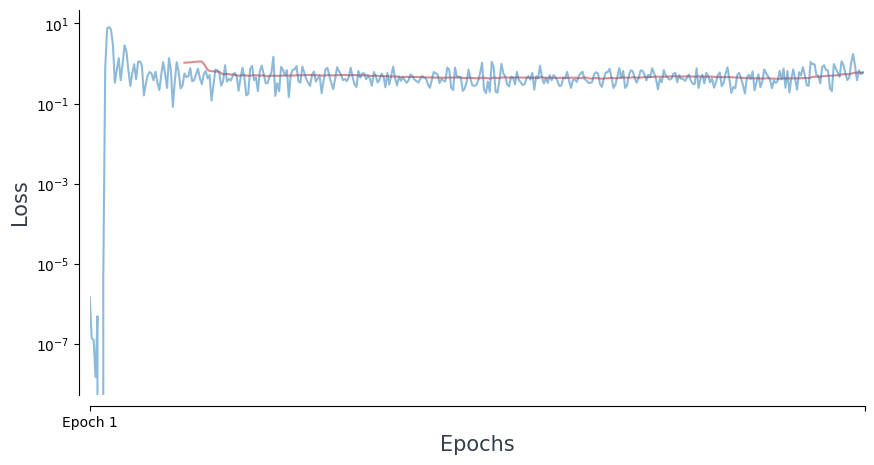

Batch:  450
    Loss:  900.9136
     Rec:    0.0005
    Disc:    0.5899
Batch:  500
    Loss:  868.1312
     Rec:    0.0005
    Disc:    0.4949
Batch:  50
    Loss: 1740.0271
     Rec:    0.0005
    Disc:    0.4842
Batch:  100
    Loss: 2169.0193
     Rec:    0.0005
    Disc:    1.0115
Batch:  150
    Loss: 1672.2345
     Rec:    0.0005
    Disc:    0.6297
Batch:  200
    Loss: 1669.2476
     Rec:    0.0004
    Disc:    0.5722
    Val Disc: 0.545


<Figure size 640x480 with 0 Axes>

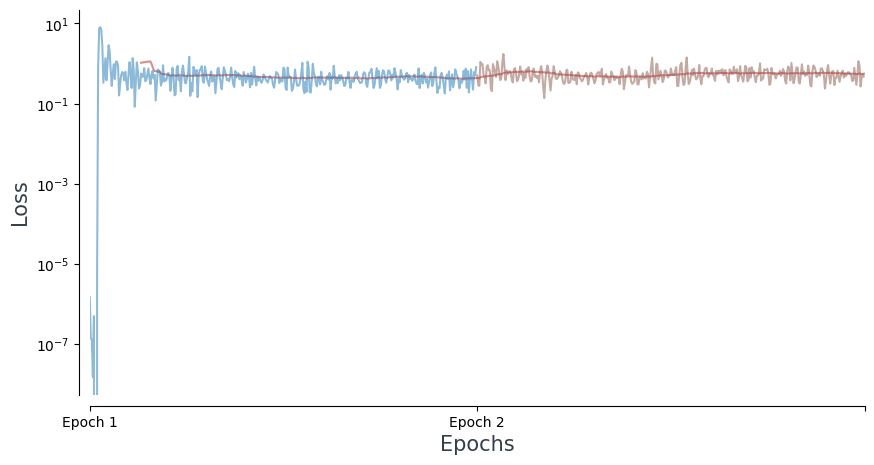

Batch:  250
    Loss: 1268.2720
     Rec:    0.0004
    Disc:    0.3741
Batch:  300
    Loss: 1907.9679
     Rec:    0.0005
    Disc:    0.4555
Batch:  350
    Loss: 1752.0857
     Rec:    0.0004
    Disc:    0.7700
Batch:  400
    Loss: 1691.9952
     Rec:    0.0005
    Disc:    0.5711
    Val Disc: 0.531


<Figure size 640x480 with 0 Axes>

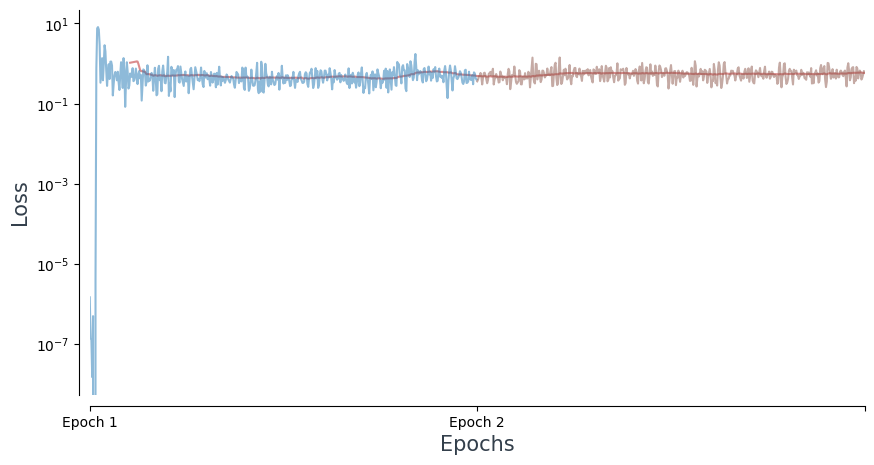

Batch:  450
    Loss: 1558.4573
     Rec:    0.0005
    Disc:    0.2433
Batch:  500
    Loss: 1791.5188
     Rec:    0.0004
    Disc:    0.8341


<Figure size 640x480 with 0 Axes>

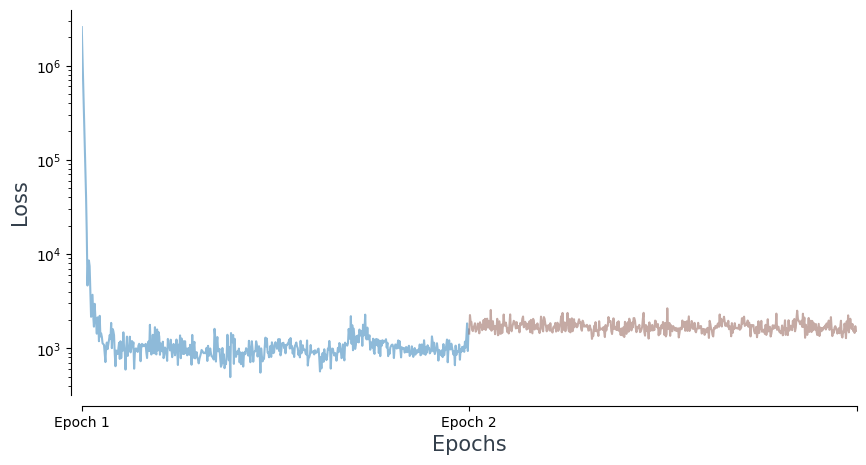

<Figure size 640x480 with 0 Axes>

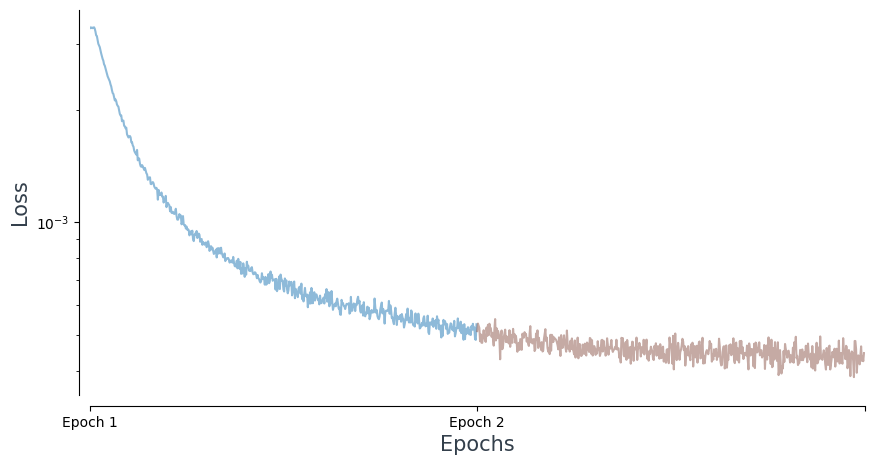

<Figure size 640x480 with 0 Axes>

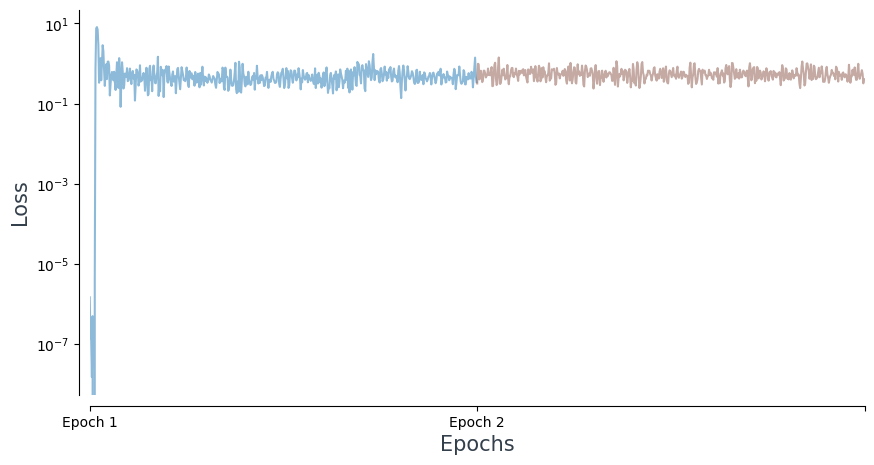

Epochs:   0%|          | 0/2 [00:00<?,?it/s]

Batches:   0%|          | 0/55 [00:00<?,?it/s]

Batch:  50
    Loss:    1.6744
     Rec:    0.0004
    Disc:    0.0000
Batch:  50
    Loss:    1.5250
     Rec:    0.0003
    Disc:    0.0000


Epochs:   0%|          | 0/2 [00:00<?,?it/s]

Batches:   0%|          | 0/541 [00:00<?,?it/s]

Batch:  0
    Loss:  202.8327


<Figure size 640x480 with 0 Axes>

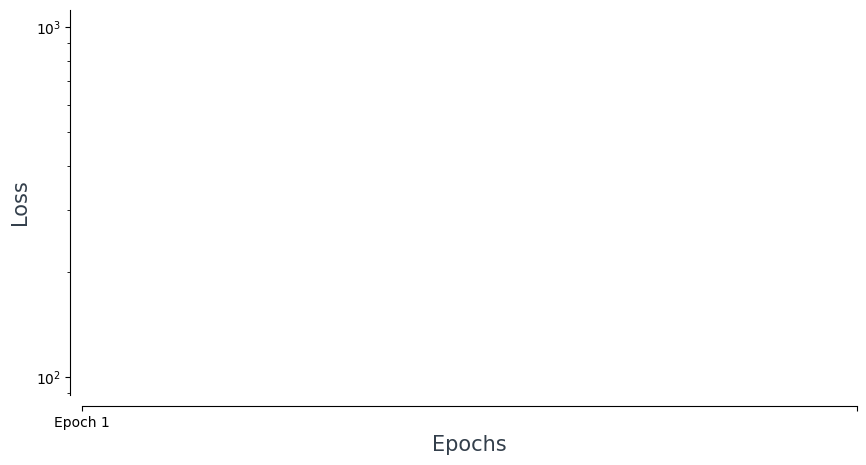

Batch:  50
    Loss:  158.2192
Batch:  100
    Loss:  140.8496
Batch:  150
    Loss:  126.1928
Batch:  200
    Loss:  138.1760


<Figure size 640x480 with 0 Axes>

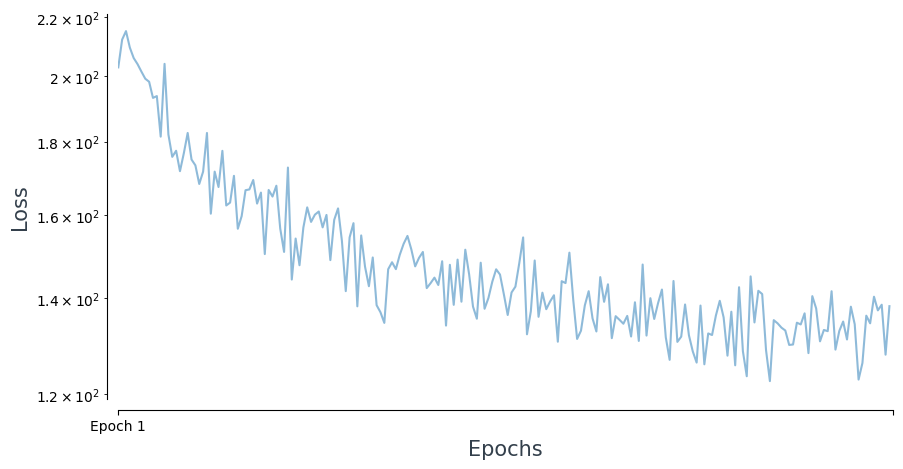

Batch:  300
    Loss:  122.4559
Batch:  350
    Loss:  123.9938
Batch:  400
    Loss:  124.6632


<Figure size 640x480 with 0 Axes>

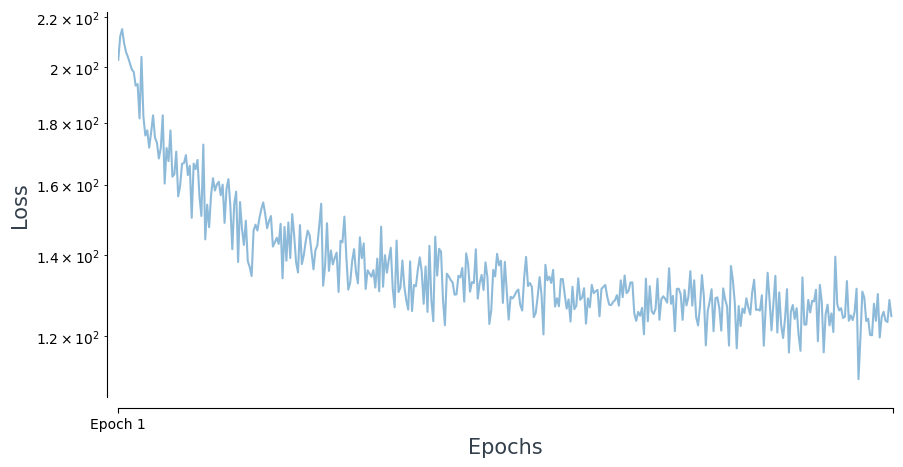

Batch:  450
    Loss:  122.2717
Batch:  500
    Loss:  132.0046
Batch:  0
    Loss:  109.6775


<Figure size 640x480 with 0 Axes>

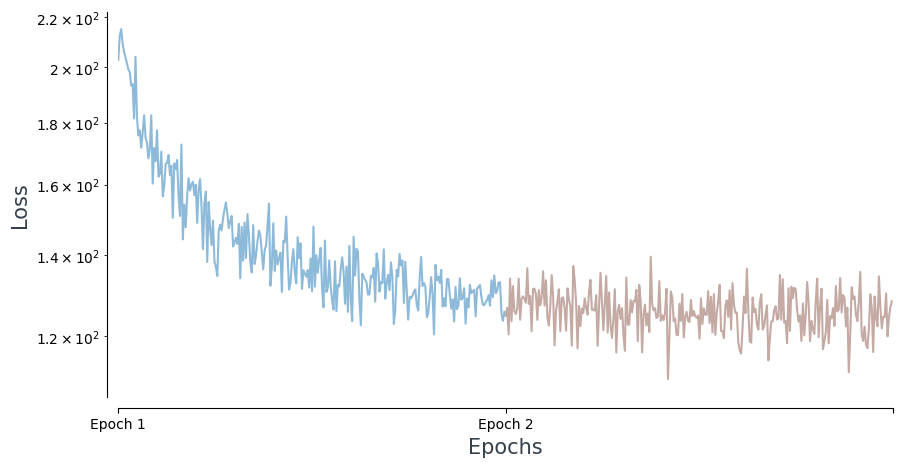

Batch:  50
    Loss:  121.7512
Batch:  100
    Loss:  124.5939
Batch:  150
    Loss:  126.8476
Batch:  200
    Loss:  121.3127


<Figure size 640x480 with 0 Axes>

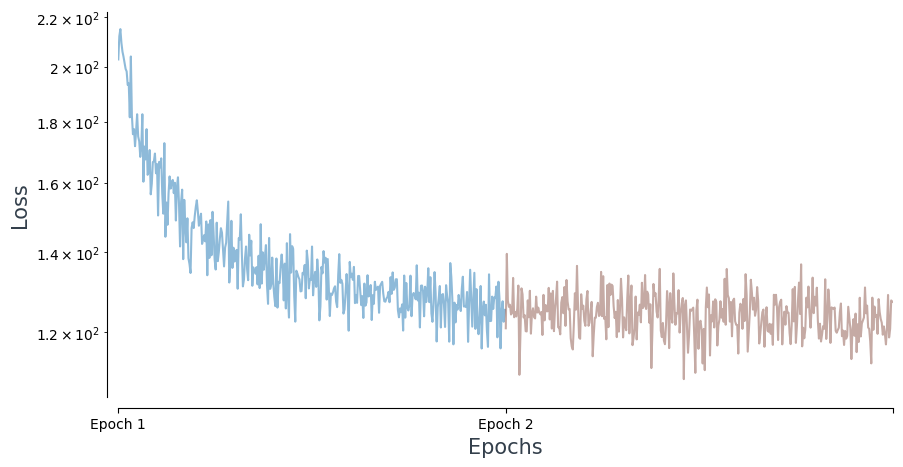

Batch:  250
    Loss:  128.3676
Batch:  300
    Loss:  119.4425
Batch:  350
    Loss:  126.3908
Batch:  400
    Loss:  121.0566


<Figure size 640x480 with 0 Axes>

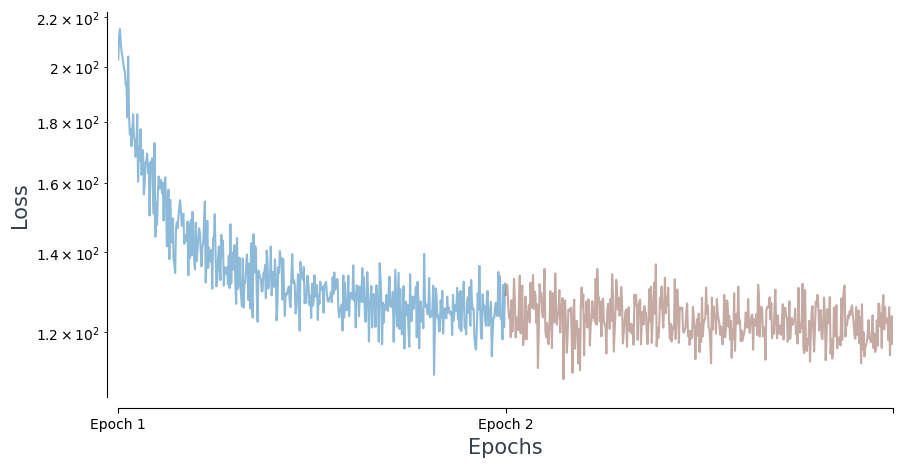

Batch:  450
    Loss:  123.7186
Batch:  500
    Loss:  115.6037


Epochs:   0%|          | 0/2 [00:00<?,?it/s]

Batches:   0%|          | 0/55 [00:00<?,?it/s]

Batch:  0
    Loss:   30.4935


<Figure size 640x480 with 0 Axes>

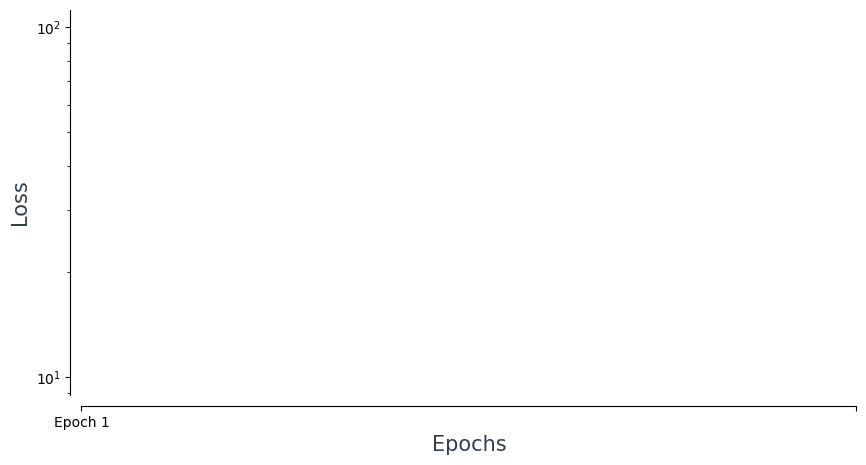

Batch:  50
    Loss:   28.5180
Batch:  0
    Loss:   28.1698


<Figure size 640x480 with 0 Axes>

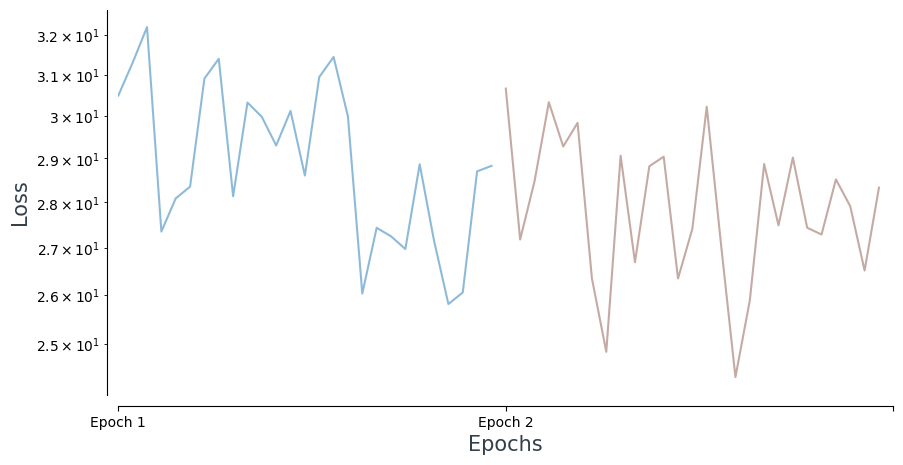

Batch:  50
    Loss:   26.2440


Batches:   0%|          | 0/568 [00:00<?,?it/s]

<Figure size 640x480 with 0 Axes>

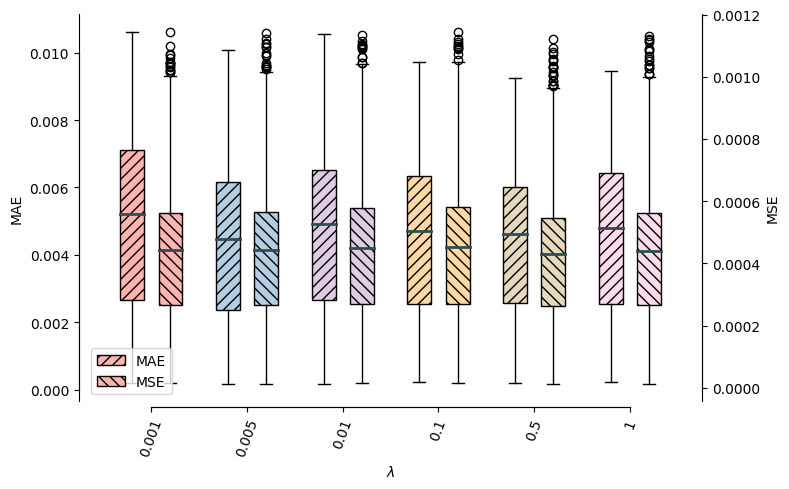

Epochs:   0%|          | 0/2 [00:00<?,?it/s]

Batches:   0%|          | 0/541 [00:00<?,?it/s]

Batch:  50
    Loss:  764.2785
     Rec:    0.0019
    Disc:    0.6535


KeyboardInterrupt: 

In [5]:
##############################################################################
########################## INSTANTIATING THE MODEL ###########################
##############################################################################
AE_K_CHEB = 3
AE_CONV_DIM = 16
AE_LINEAR_DIM = 8
AE_DROPOUT = 0.5
AE_ACTIVATION = 'tanh'

AE_parameters = {
    'K_cheb': AE_K_CHEB,
    'conv_dim': AE_CONV_DIM,
    'linear_dim': AE_LINEAR_DIM,
    'dropout': AE_DROPOUT,
    'activation': AE_ACTIVATION,
    'num_channels': NUM_CHANNELS,
    'device': device,
}

DD_SEQ_LEN = 12
DD_FEAT_DIM = AE_LINEAR_DIM
DD_LEFT_NODES = 1750
DD_parameters = {
    'seq_len': DD_SEQ_LEN,
    'feat_dim': DD_FEAT_DIM,
    'left_nodes': DD_LEFT_NODES,
}

# autoencoder linear dims + 4 sin-cos time features
PRED_FEATURES   = AE_LINEAR_DIM + 4
PRED_LINEAR_DIM = 32
PRED_PERIODS_IN = 12
PRED_PERIODS_OUT = [0, 1, 2, 5, 8, 11]
PRED_ACTIVATION  = 'relu'

PR_parameters = {
    'features': PRED_FEATURES,
    'linear_dim': PRED_LINEAR_DIM,
    'periods_in': PRED_PERIODS_IN,
    'periods_out': PRED_PERIODS_OUT,
    'activation': PRED_ACTIVATION,
    'num_channels': NUM_CHANNELS,
    'device': device,
    'batch_size': BATCH_SIZE,
    
}
num_epochs = EPOCHS
dataloaders = train_dataloader, target_dataloader, targettest_dataloader
AE_criterion = nn.MSELoss()
PR_criterion = nn.MSELoss()
optimizer_parameters = 5e-4, 5e-5
BATCH_SIZE = BATCH_SIZE
dd_lambda = 0

folder = osp.join('training logs', 'models', exp_id)
check_dir(folder)
test_errors = {}

dd_lambdas = [1e-3, 5e-3, 1e-2, 1e-1, 5e-1, 1, 1.5, 2]
dd_accs = []

for dd_lambda in dd_lambdas:
    model = Model(
        AE_parameters=AE_parameters,
        DD_parameters=DD_parameters,
        PR_parameters=PR_parameters,
        num_epochs=num_epochs,
        dataloaders=dataloaders,
        AE_criterion=AE_criterion,
        PR_criterion=PR_criterion,
        optimizer_parameters=optimizer_parameters,
        BATCH_SIZE=BATCH_SIZE,
        dd_lambda=dd_lambda,
        folder=folder,
        specs=f'{dd_lambda}'.replace('.', ''),
        tgt=tgt,
        val_dl=val_dataloader
    ).to(device)
    
    model.load_module('autoencoder', model.folder, f'ae_{model.specs}.pth')    
    model.load_module('discriminator', model.folder, f'dd_{model.specs}.pth')    
    model.load_module('predictor', model.folder, f'pred_{model.specs}.pth')

    model.ae_train('pretrain', save=False, lambda_update=1.5, plot=1)
    model.ae_train('finetune', save=True)

    dd_acc = model.dd_test()
    dd_accs.append(dd_acc)

    model.pred_train('pretrain', save=False)
    model.pred_train('finetune', save=True)
    
    errors = model.pred_test()
    test_errors[dd_lambda] = errors
    plot_losses_boxplot(
        test_errors, 
        r'$\lambda$', 
        save=False, 
        exp_id=exp_id,
    )

plot_losses_boxplot(
    test_errors, 
    r'$\lambda$', 
    save=True,
    exp_id=exp_id,
)


Batches:   0%|          | 0/568 [00:00<?,?it/s]

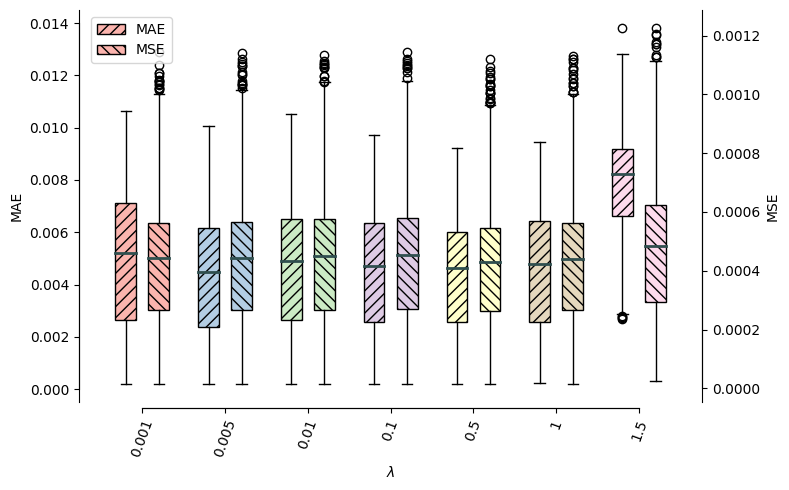

In [6]:
model = Model(
    AE_parameters=AE_parameters,
    DD_parameters=DD_parameters,
    PR_parameters=PR_parameters,
    num_epochs=num_epochs,
    dataloaders=dataloaders,
    AE_criterion=AE_criterion,
    PR_criterion=PR_criterion,
    optimizer_parameters=optimizer_parameters,
    BATCH_SIZE=BATCH_SIZE,
    dd_lambda=0,
    folder=folder,
    specs=f'{dd_lambda}'.replace('.', ''),
    tgt=tgt,
    val_dl=val_dataloader
).to(device)

model.load_module('autoencoder', model.folder, f'ae_{model.specs}.pth')    
model.load_module('discriminator', model.folder, f'dd_{model.specs}.pth')    
model.load_module('predictor', model.folder, f'pred_{model.specs}.pth')
errors = model.pred_test()
test_errors[dd_lambda] = errors
plot_losses_boxplot(test_errors, r'$\lambda$', save=False)

In [8]:
test_errors[0] = test_errors[1.5]

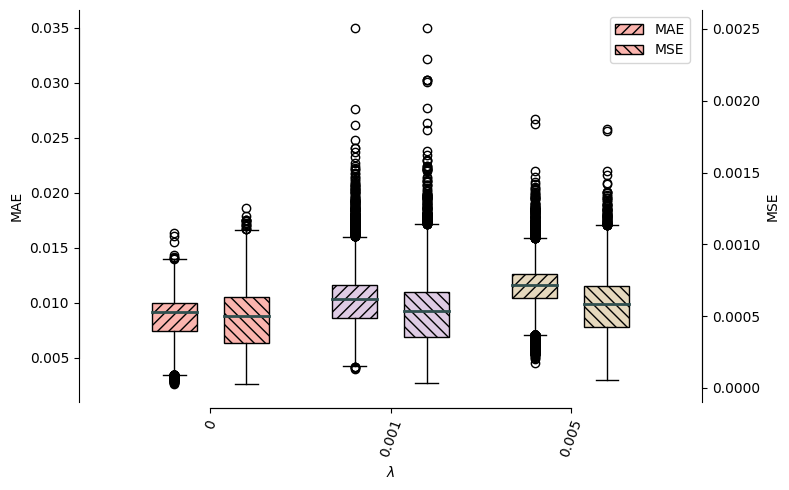

In [7]:
plot_losses_boxplot(test_errors, r'$\lambda$', save=False)

In [12]:
plot_losses_boxplot(dict(sorted(test_errors.items())), r'$\lambda$', save=True)

<Figure size 800x500 with 0 Axes>

In [ ]:
dd_lambdas = [1, 1.5, 2]
for dd_lambda in dd_lambdas:
    model = Model(
        AE_parameters=AE_parameters,
        DD_parameters=DD_parameters,
        PR_parameters=PR_parameters,
        num_epochs=num_epochs,
        dataloaders=dataloaders,
        AE_criterion=AE_criterion,
        PR_criterion=PR_criterion,
        optimizer_parameters=optimizer_parameters,
        BATCH_SIZE=BATCH_SIZE,
        dd_lambda=dd_lambda,
        folder=folder,
        specs=f'{dd_lambda}',
        tgt=tgt,
        val_dl=val_dataloader
    ).to(device)

    print('='*79)
    print('='*20, f'{dd_lambda=}', '='*20)
    print('='*20, f'PT AE', '='*20)
    model.ae_train('pretrain', save=False, lambda_update=1.5, plot=1)
    print('='*20, f'FT AE', '='*20)
    model.ae_train('finetune', save=True)

    dd_acc = model.dd_test()
    dd_accs.append(dd_acc)

    print('='*20, f'PT PR', '='*20)
    model.pred_train('pretrain', save=False)
    print('='*20, f'FT PR', '='*20)
    model.pred_train('finetune', save=True)

    errors = model.pred_test()
    test_errors[dd_lambda] = errors
    
plot_losses_boxplot(test_errors, r'$\lambda$', save=True)

with open('temp.txt', 'w') as f:
    for i, dd_lambda in enumerate([0, 1e-3, 5e-3, 1e-2, 1e-1, 5e-1, 1, 1.5, 2]):
        f.write(str(dd_lambda) + ': ' + str(dd_accs[i]) + '\n')

==================== dd_lambda=1 ====================
==================== PT AE ====================


Epochs:   0%|          | 0/1 [00:00<?,?it/s]

Batches:   0%|          | 0/541 [00:00<?,?it/s]

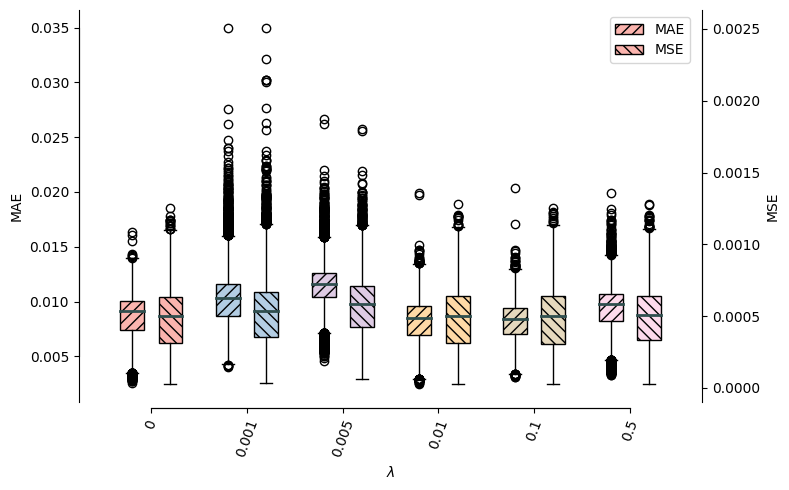

In [15]:
plot_losses_boxplot(test_errors, r'$\lambda$', save=False)

In [13]:
dd_accs

[0.5082789179104478, 0.5, 0.5, 0.5, 0.5]

In [16]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    parts = {}
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        part = name.split('.')[0]
        if part not in parts:
            parts[part] = 0
        parts[part] += params
    for part, params in parts.items():
        table.add_row([part, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+---------+------------+
| Modules | Parameters |
+---------+------------+
|    ae   |    9089    |
|    dd   |  98042009  |
|   pred  |    8566    |
+---------+------------+
Total Trainable Params: 98059664


98059664